We first start by defining the 2D darcy flow on a geometry using a mask on a gaussian field. The solver needs to be run for each mask since it comes with a different boundary condition.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#@title generate gaussian field with push forward

def generate_random_field_2D(Nx, Ny, Lx, Ly, scale=1, shift=9):
    """
    Generate a 2D random field sampled from N(0, scale * (-Delta + shift*I)^-2) on a periodic domain.

    We apply a push forward which maps negatives to 3 and non-negatives to 12

    Parameters:
        Nx, Ny (int): Number of grid points in x and y directions.
        Lx, Ly (float): Domain lengths in x and y directions.
        scale (float): Scaling factor for the covariance operator (default 625).
        shift (float): Shift parameter in the operator (default 25).

    Returns:
        x (ndarray): x-coordinates of the grid points.
        y (ndarray): y-coordinates of the grid points.
        field (ndarray): Sampled 2D random field.
    """
    # Define spatial grid
    x = np.linspace(0, Lx, Nx)
    y = np.linspace(0, Ly, Ny)
    kx = np.fft.fftfreq(Nx, d=Lx/Nx) * 2 * np.pi
    ky = np.fft.fftfreq(Ny, d=Ly/Ny) * 2 * np.pi
    KX, KY = np.meshgrid(kx, ky, indexing="ij")  # Wavenumber grid

    # Compute eigenvalues of the covariance operator
    eigenvalues = scale / ((KX**2 + KY**2) + shift)**2

    # Sample from Fourier coefficients
    random_coeffs = (np.random.normal(0, np.sqrt(eigenvalues)) +
                     1j * np.random.normal(0, np.sqrt(eigenvalues)))

    # Ensure reality of the field (complex conjugate symmetry)
    random_coeffs[Nx//2+1:, Ny//2+1:] = np.conj(random_coeffs[1:Nx//2, 1:Ny//2][::-1, ::-1])

    # Transform back to physical space
    field = np.fft.ifft2(random_coeffs).real

    field = np.where(field < 0, 3, 12)


    return x, y, field

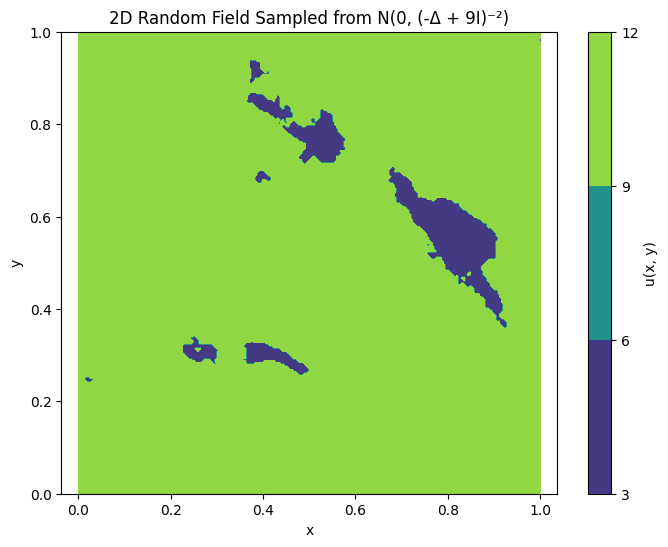

In [ ]:
# Parameters
Nx, Ny = 256, 256  # Number of grid points in x and y directions
Lx, Ly = 1.0, 1.0  # Domain lengths in x and y directions

# Generate the 2D random field
x, y, field = generate_random_field_2D(Nx, Ny, Lx, Ly)

# Plot the result
X, Y = np.meshgrid(x, y, indexing="ij")
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, field, levels=2, cmap="viridis")
plt.colorbar(label="u(x, y)")
plt.title("2D Random Field Sampled from N(0, (-Δ + 9I)⁻²)")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.show()

In [ ]:
x.shape

(256,)

Given a masking function which describes the geometry of D and the boundary conditions, solve the PDE and output (a(x), u(x)) input-output pair

In [ ]:
def solve_darcy_flow_with_general_geometries(N, mask, tol=1e-5, max_iter=2000):
    """
    Solve div(a(x, y) grad(u)) = f(x, y) with u = 0 on the boundary using a basic finite difference scheme.

    Parameters:
    - N: Number of grid points per dimension
    - a_func: Function a(x, y), the coefficient of the equation.
    - f_func: Function f(x, y), the forcing term.
    - tol: Convergence tolerance for the iterative solver.
    - max_iter: Maximum number of iterations for the solver.

    Returns:
    - u: Solution array of shape (N, N), including boundaries.
    - a: Coefficient array of shape (N, N).
    - x, y: Grid points (including boundaries) for visualization.
    """
    # Grid setup
    L = 1.0  # Domain length
    h = L / (N - 1)  # Grid spacing
    x = np.linspace(0, L, N)
    y = np.linspace(0, L, N)
    X, Y = np.meshgrid(x, y, indexing="ij")

    # Coefficient a(x, y)
    a = generate_random_field_2D(N, N, L, L)[2]

    # set boundary conditions via mask
    a[mask==0] = 0

    # constant forcing = 1
    f = 1

    # Initialize solution u with boundary conditions
    u = np.zeros((N, N))  # Including boundaries

    # Iterative solver: Jacobi method
    for k in range(max_iter):
        u_old = u.copy()

        # Update interior points using the finite difference scheme
        for i in range(N):
            for j in range(N):
                if mask[i, j]:
                    a_e = 0.5 * (a[i, j] + a[i + 1, j])  # Coefficient to the east
                    a_w = 0.5 * (a[i, j] + a[i - 1, j])  # Coefficient to the west
                    a_n = 0.5 * (a[i, j] + a[i, j + 1])  # Coefficient to the north
                    a_s = 0.5 * (a[i, j] + a[i, j - 1])  # Coefficient to the south

                    u[i, j] = (
                        a_e * u_old[i + 1, j]
                        + a_w * u_old[i - 1, j]
                        + a_n * u_old[i, j + 1]
                        + a_s * u_old[i, j - 1]
                        - h**2 * f
                    ) / (a_e + a_w + a_n + a_s)

        # Convergence check
        diff = np.max(np.abs(u - u_old))
        if diff < tol:
            print(f"Converged in {k} iterations.")
            break
    else:
        print("Maximum iterations reached without convergence.")

    return u, a, x, y

In [ ]:
#@title visualisation code

def visualise_solution(u, a, x, y, show=True):
  # Visualize a(x, y) and u(x, y) side by side
  X, Y = np.meshgrid(x, y, indexing="ij")
  plt.figure(figsize=(12, 6))

  # Plot a(x, y)
  plt.subplot(1, 2, 1)
  plt.contourf(X, Y, a, levels= 4, cmap="viridis")
  plt.colorbar(label="a(x, y)")
  plt.title("Coefficient a(x, y)")
  plt.xlabel("x")
  plt.ylabel("y")

  # Plot u(x, y)
  plt.subplot(1, 2, 2)
  plt.contourf(X, Y, u, levels=100, cmap="viridis")
  plt.colorbar(label="u(x, y)")
  plt.title("Solution u(x, y)")
  plt.xlabel("x")
  plt.ylabel("y")

  plt.tight_layout()
  if show:
    plt.show()


In [ ]:
def mask_generator(N, shape='box'):

  # initialise
  mask = np.zeros((N, N))

  if shape=='box':
    mask[1:-1, 1:-1] = 1

  if shape=='torus1':
    for i in range(N):
      for j in range(N):
        if (i-N//2)**2 + (j-N//2)**2 < (N/2.2)**2:
            mask[i,j] = 1
        if (i-N//2)**2 + (j-N//2)**2 < (N/6)**2:
            mask[i,j] = 0

  if shape=='torus2':
    for i in range(N):
      for j in range(N):
        if (i-N//2)**2 + (j-N//2)**2 < (N/2.2)**2:
            mask[i,j] = 1
        if (i-N//4)**2 + (j-N//2)**2 < (N/8)**2:
            mask[i,j] = 0
        if (i-3*N//4)**2 + (j-N//2)**2 < (N/8)**2:
            mask[i,j] = 0

  if shape=='triangle':
    # Calculate the height of the triangle
    triangle_height = N-5

    # Center of the array
    cx = N // 2

    # Loop through the rows of the triangle
    for y in range(triangle_height):
        # Calculate the width of the triangle at the current row
        half_width = y // 2

        # Define the start and end indices for the row
        start_x = cx - half_width
        end_x = cx + half_width + 1

        # Fill the row with 1s
        mask[y, start_x:end_x] = 1

  if shape=='bean':

    num_points = 50
    a, b, c = 1.2, 0,-0.2
    circle_radius = 11.5

    # Generate normalized x values for the quadratic curve
    x_vals = np.linspace(-0.6, 0.6, num_points)
    y_vals = a * x_vals**2 + b * x_vals + c

    # Scale x and y values to pixel coordinates
    x_pixel = ((x_vals + 1) * (N // 2)).astype(int)
    y_pixel = ((1 - y_vals) * (N // 2)).astype(int)  # Invert y-axis for array indexing

    # Draw circles along the curve
    for x, y in zip(x_pixel, y_pixel):
        # Create a grid of indices for the circle
        y_grid, x_grid = np.ogrid[:N, :N]
        distance = (x_grid - x)**2 + (y_grid - y)**2
        mask[distance <= circle_radius**2] = 1


  return mask

Converged in 426 iterations.


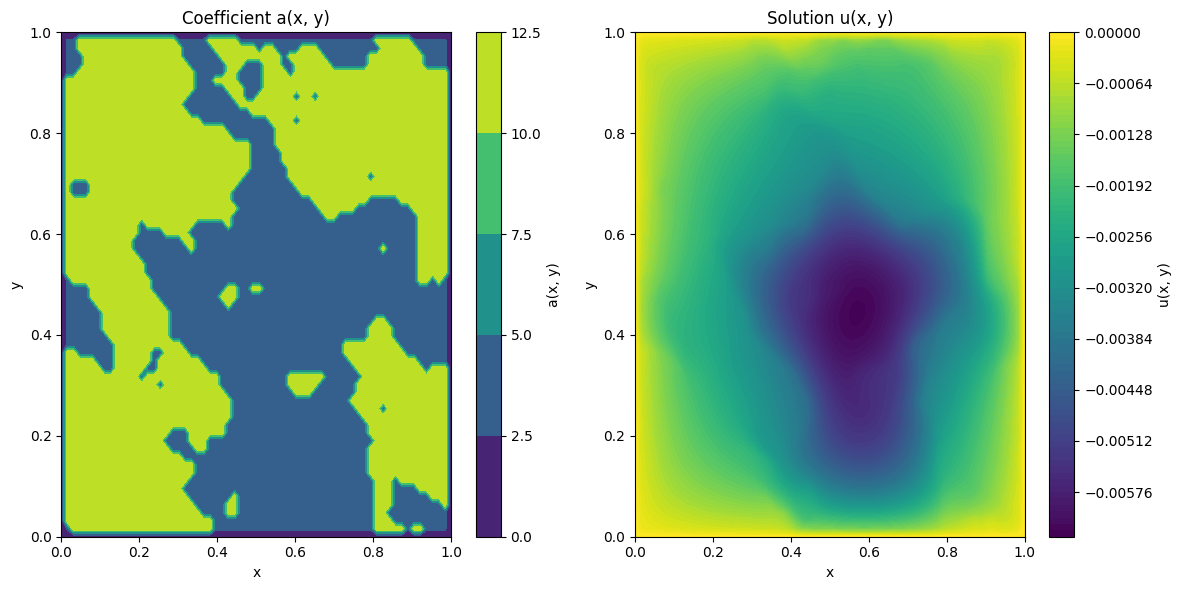

In [ ]:
N = 64

# box
mask = mask_generator(N, shape='box')

u, a, x, y = solve_darcy_flow_with_general_geometries(N, mask)

visualise_solution(u, a, x, y)

Converged in 5 iterations.


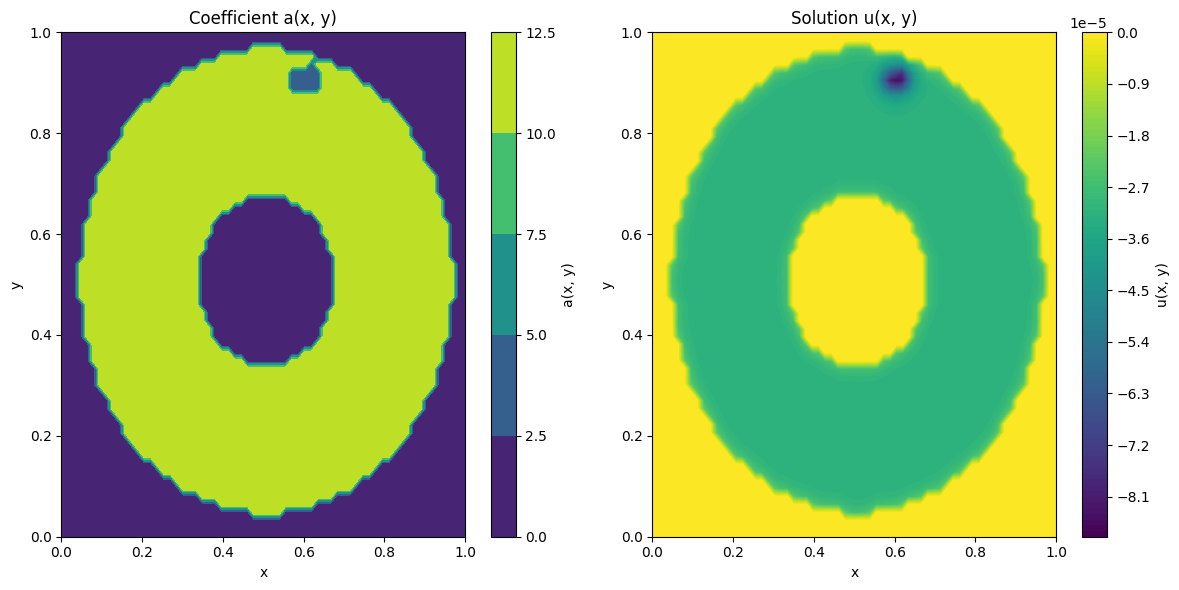

In [ ]:
N = 64

# donut
mask = mask_generator(N, shape='torus1')
u, a, x, y = solve_darcy_flow_with_general_geometries(N, mask)

visualise_solution(u, a, x, y)

Converged in 46 iterations.


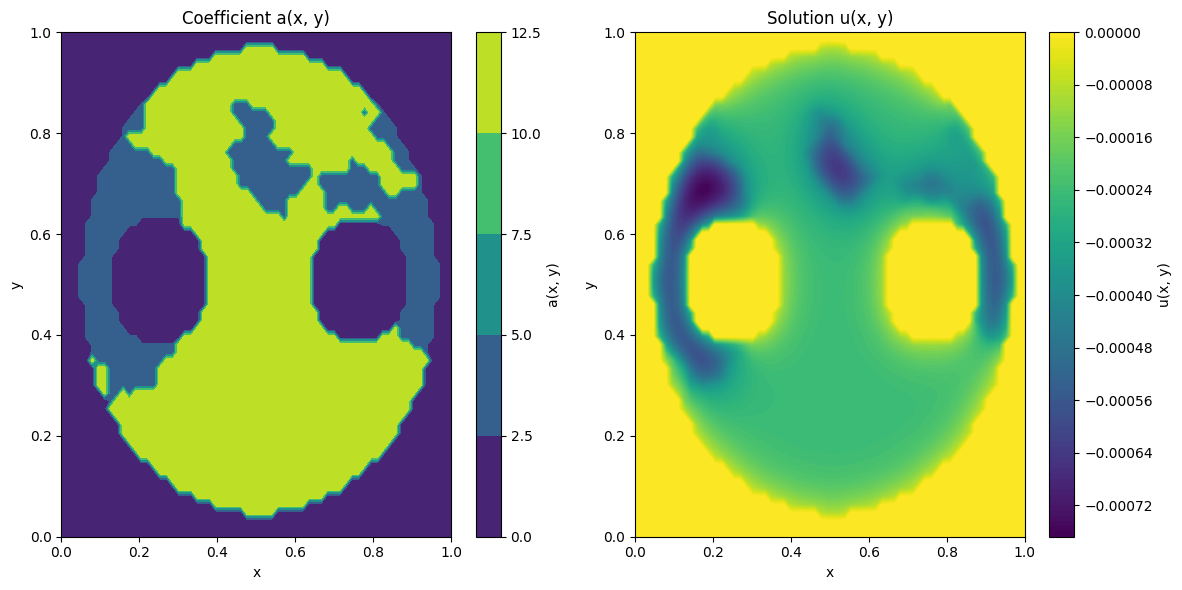

In [ ]:
N = 64

# donut
mask = mask_generator(N, shape='torus2')
u, a, x, y = solve_darcy_flow_with_general_geometries(N, mask)

visualise_solution(u, a, x, y)

Converged in 133 iterations.


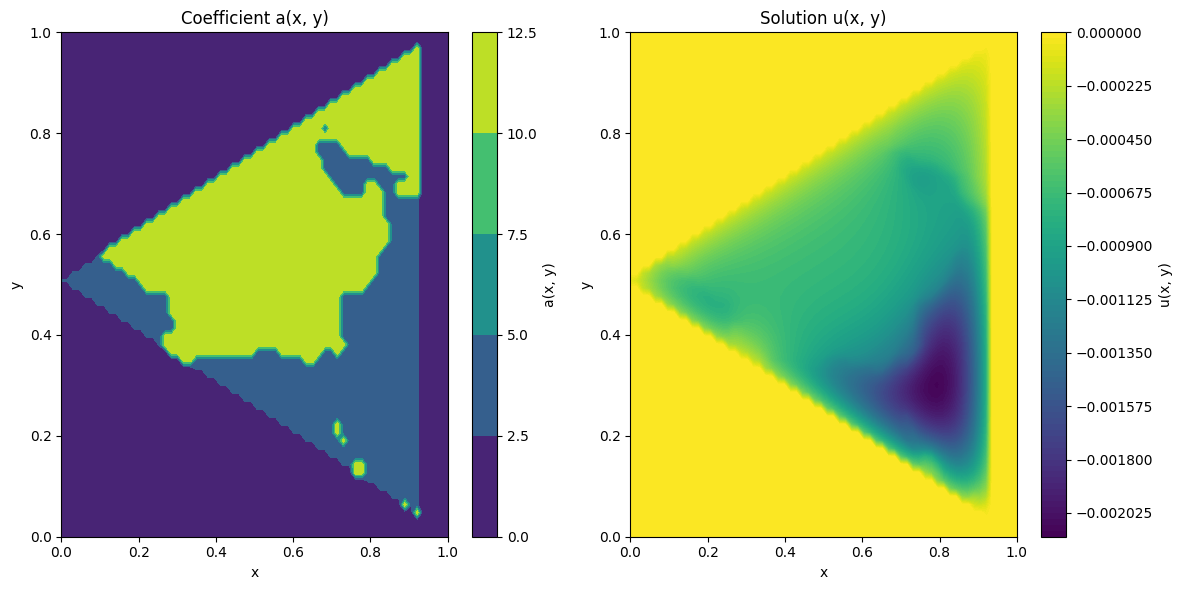

In [ ]:
N = 64

# triangle
mask = mask_generator(N, shape='triangle')
u, a, x, y = solve_darcy_flow_with_general_geometries(N, mask)

visualise_solution(u, a, x, y)

Converged in 251 iterations.


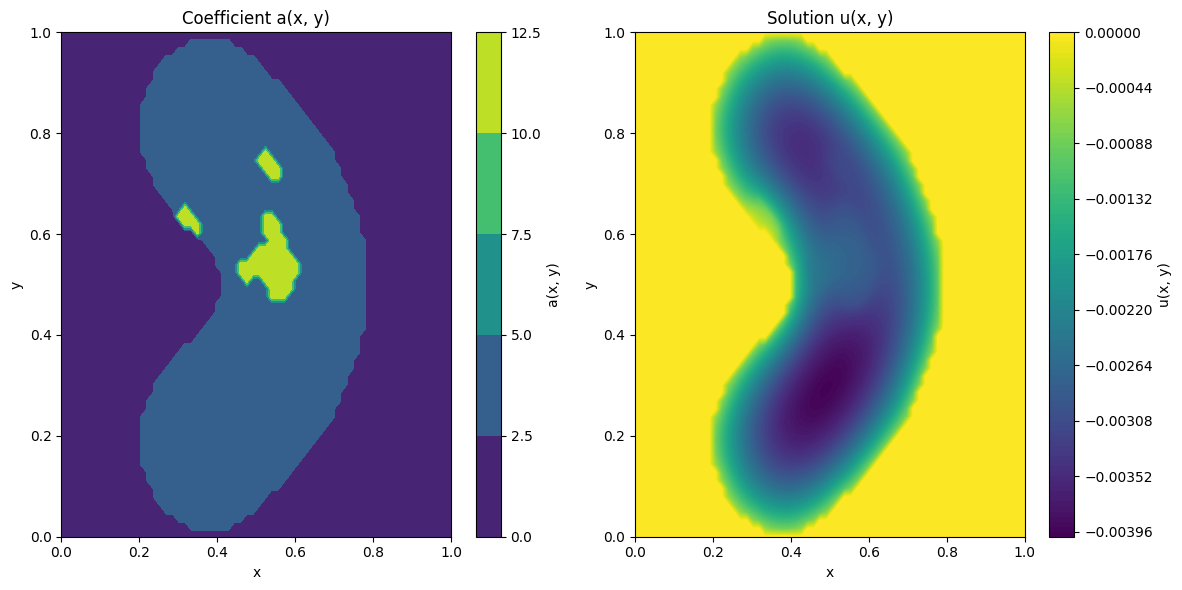

In [ ]:
N = 64

# bean
mask = mask_generator(N, shape='bean')
u, a, x, y = solve_darcy_flow_with_general_geometries(N, mask)

visualise_solution(u, a, x, y)

In [ ]:
def sample_indices(mask, percentage_sampled):
  indices_list = []
  for i in range(N):
    for j in range(N):
      if mask[i,j] == 1:
        indices_list.append((i,j))

  no_indices = len(indices_list)

  #randomly choose percentage_sampled % of the indices

  chosen_indices_idx = np.random.choice(no_indices, int(no_indices*percentage_sampled), replace=False)
  chosen_indices = [indices_list[i] for i in chosen_indices_idx]

  return chosen_indices


We need to now convert these solutions into a dataset that randomly samples the n% of the domain

In [ ]:
N = 64

mask = mask_generator(N, shape='torus2')
percentage_sampled = 0.2

chosen_indices = sample_indices(mask, percentage_sampled)

Converged in 226 iterations.


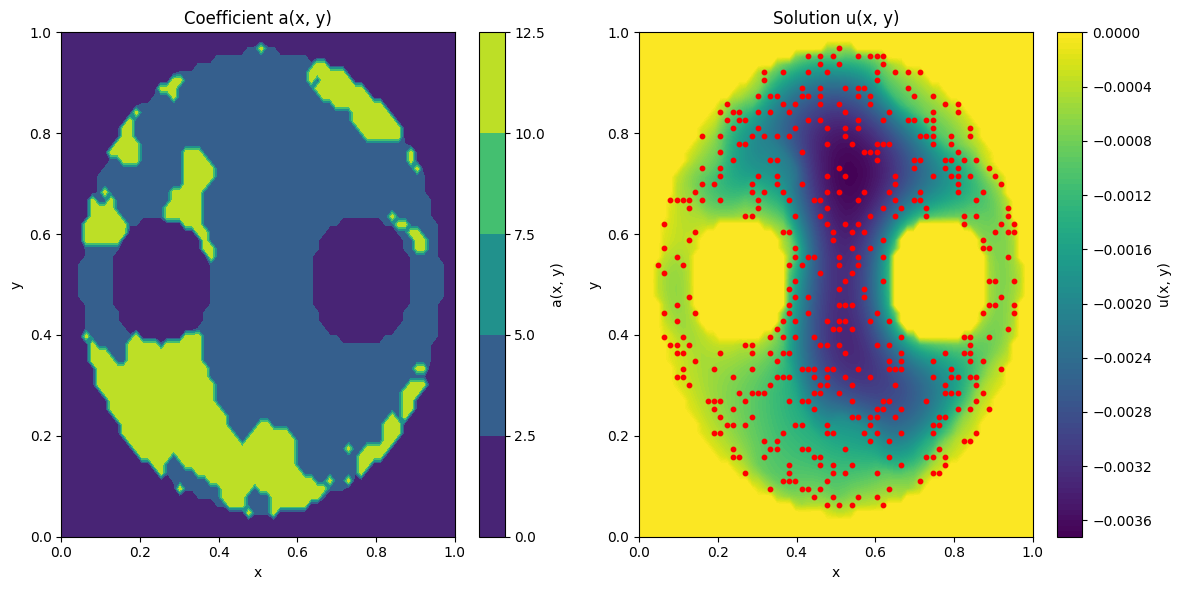

In [ ]:
# visualise where we sample the domain
u, a, x, y = solve_darcy_flow_with_general_geometries(N, mask)

visualise_solution(u, a, x, y, show=False)

# Extract x and y coordinates of sampled points
sampled_x = [x[i] for i, j in chosen_indices]
sampled_y = [y[j] for i, j in chosen_indices]

# Plot sampled points on top of the contour
plt.scatter(sampled_x, sampled_y, color='red', s=10, label='Sampled Points')
plt.show()

We need to now format this for the input

In [ ]:
def generate_input_output_list(N_grid, mask, N_input_outputs):
  input_output_list = []
  for i in range(N_input_outputs):
    u, a, x, y = solve_darcy_flow_with_general_geometries(N_grid, mask)
    input_output_list.append((a, u))
  return input_output_list, x, y

In [ ]:
N = 64
mask = mask_generator(N, shape='torus2')

input_output_list, x, y = generate_input_output_list(N, mask, N_input_outputs=3)

percentage_sampled = 0.2
chosen_indices = sample_indices(mask, percentage_sampled)

Converged in 61 iterations.
Converged in 291 iterations.
Converged in 92 iterations.


Data Generation

In [ ]:
import torch

def generate_CORAL_dataset(N_input_output_pairs, domain_shape, percentages_sampled, N_grid=64):

  dim_in = 2
  dim_out = 1

  # create the mask according to specified domain geometry
  mask = mask_generator(N_grid, shape=domain_shape)
  # generate the a,u pairs by solving 2D darcy flow on mask-specified BCs
  input_output_list, x, y = generate_input_output_list(N, mask, N_input_outputs=N_input_output_pairs)

  coordinates_a_u_list = []

  for percentage_sampled in percentages_sampled:

    # sample the domain
    chosen_indices = sample_indices(mask, percentage_sampled)

    # generate the coordinates, a_features and u_features tensors used in the encoding/decoding stage
    coordinates = torch.tensor([[x[index[0]], y[index[1]]] for index in chosen_indices]).repeat(len(input_output_list), 1, 1)

    # initialise features tensors
    a_features = torch.zeros(coordinates.shape[0], coordinates.shape[1], dim_out)
    u_features = torch.zeros_like(a_features)

    # use the same input_output_list but sample at different rates
    for k, input_output in enumerate(input_output_list):
      a, u = input_output

      a_sampled = [a[i, j] for i, j in chosen_indices]
      u_sampled = [u[i, j] for i, j in chosen_indices]

      a_features[k] = torch.tensor(a_sampled).unsqueeze(-1)
      u_features[k] = torch.tensor(u_sampled).unsqueeze(-1)

    coordinates_a_u_list.append((coordinates, a_features, u_features))

  return coordinates_a_u_list, input_output_list, x, y

In [ ]:
import pickle

percentages_sampled = [0.5]
percentages_sampled_string = '_'.join(map(str, percentages_sampled))

N_input_output_pairs = 1200


for shape in ['bean', 'torus1', 'torus2', 'triangle', 'box']:

  coordinates_a_u_list, input_output_list, x, y = generate_CORAL_dataset(N_input_output_pairs=N_input_output_pairs, domain_shape=shape, percentages_sampled=percentages_sampled , N_grid=64)

  dataset = (coordinates_a_u_list, input_output_list, x, y)


  with open(f'/content/drive/MyDrive/Files_for_CORAL/dataset_{shape}_{percentages_sampled_string}_{N_input_output_pairs}.pkl', 'wb') as f:
      pickle.dump(dataset, f)

Streaming output truncated to the last 5000 lines.
Converged in 241 iterations.
Converged in 105 iterations.
Converged in 262 iterations.
Converged in 157 iterations.
Converged in 170 iterations.
Converged in 18 iterations.
Converged in 272 iterations.
Converged in 1 iterations.
Converged in 283 iterations.
Converged in 0 iterations.
Converged in 79 iterations.
Converged in 257 iterations.
Converged in 281 iterations.
Converged in 97 iterations.
Converged in 246 iterations.
Converged in 256 iterations.
Converged in 208 iterations.
Converged in 197 iterations.
Converged in 263 iterations.
Converged in 18 iterations.
Converged in 35 iterations.
Converged in 0 iterations.
Converged in 284 iterations.
Converged in 9 iterations.
Converged in 284 iterations.
Converged in 244 iterations.
Converged in 8 iterations.
Converged in 0 iterations.
Converged in 197 iterations.
Converged in 280 iterations.
Converged in 176 iterations.
Converged in 247 iterations.
Converged in 27 iterations.
Converged 

In [ ]:
coordinates.shape, a_features.shape, u_features.shape

In [ ]:
a[1, 2, 3]

abc